In [ ]:
# Se inicio el documento

In [1]:
#Se importan las librerias con las cuales se va a desarrollar el ejercicio

#Manejo de datos
import pandas as pd
import numpy as np
import os
import glob 
import openpyxl

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE 
from xverse.transformer import WOE
from xverse.transformer import MonotonicBinning
from xverse.ensemble import VotingSelector
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Using TensorFlow backend.


Creación de funciones personalizadas

In [2]:
## Funciones para valores perdidos.

## Porcentaje de valores perdidos por variable
def resum_missing(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje'])
    return missing_data

## dataFrame de resumen de posición de valores perdidos.  
def posmissing(df):
    lista_miss = np.where(df.isna())
    v1 = pd.Series(np.ndarray.tolist(lista_miss[0]))
    v2 = pd.Series(np.ndarray.tolist(lista_miss[1]))
    resumen_vna = pd.concat([v1, v2], axis=1, keys=['posicion_fila', 'posicion_columna'])
    return resumen_vna

In [3]:
# Lee los nombres de archivos del directorio de trabajo
filenames = glob.glob('Datos/*.csv')

In [4]:
filenames

['Datos/DatosNegativos1.csv',
 'Datos/DatosPositivos1.csv',
 'Datos/DatosValidacion1.csv']

In [5]:
# Leemos y cargamos el contenido de los archivos .xlsx
df = pd.DataFrame()
for filename in filenames:
    data = pd.read_csv(filename)
    print(data.shape)
    df = df.append(data)

(5561, 1760)
(8322, 1761)
(1623, 1762)


In [6]:
# Tamaño del set de datos completo
df.shape

(15506, 1762)

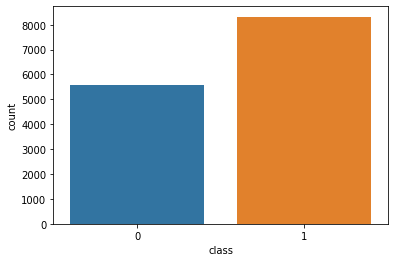

In [82]:
# Contamos los valores por clase, y vemos que la clase está desbalanceada
sns.countplot(df["class"])

Dado que la variable objetivo está desbalanceada, es necesario aplicar un método de balanceo que nos permita tener las clases equilibradas.

In [83]:
# Eliminamos la columna que ennumera del primer archivo
df_dep = df.drop(columns="Unnamed: 0")

In [84]:
df_dep.head()

,A,AA,AC,AD,AE,AF,AG,AH,AI,AK,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
0,28.571,16.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.979,0.0,1.895,0.994,0.781,0.0,0.0,0.0
1,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.769,0.0,2.119,0.028,1.000,0.0,0.0,0.0
2,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.844,0.0,0.977,0.096,0.138,0.0,0.0,0.0
3,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.564,0.0,0.504,0.096,0.095,0.0,0.0,0.0
4,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.813,0.0,0.980,0.848,0.065,0.0,0.0,0.0


In [85]:
# Creamos una columna enumerando cada fila
df_dep = df_dep.assign(num=[0 + i for i in range(len(df_dep))])[['num'] + df_dep.columns.tolist()]

In [86]:
df_dep.tail()

,num,A,AA,AC,AD,AE,AF,AG,AH,AI,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
8317,13878,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,3.404,0.0,2.520,3.511,3.691,2.329,0.240,1.653
8318,13879,33.333,0.0,0.0,0.0,0.0,0.0,12.50,0.0,0.0,...,0.0,0.0,1.537,0.0,0.941,1.213,1.282,1.165,0.048,0.000
8319,13880,6.667,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,6.170,0.0,4.833,6.313,5.053,2.881,4.180,2.857
8320,13881,5.556,0.0,0.0,0.0,0.0,0.0,5.88,0.0,0.0,...,0.0,0.0,3.430,0.0,6.001,5.297,4.848,4.387,3.797,3.346
8321,13882,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,7.002,0.0,3.670,12.909,11.567,1.463,6.780,12.438


In [87]:
# Guardamos las variables num y sequence
df_1 = df_dep[["num", "sequence"]]
df_1.tail()

,num,sequence
8317,13878,ILPIIGKILSTIFGK
8318,13879,YAGAVANDL
8319,13880,KKCFRWQWRMKKLGA
8320,13881,GWAGWLLSPRGSRPSWGP
8321,13882,LRRLYKRVVKLWKRLFRQLRRPVR


In [88]:
# Eliminamos la variable sequence del dataframe depurado
df_dep.pop("sequence")
df_dep.head()

,num,A,AA,AC,AD,AE,AF,AG,AH,AI,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
0,0,28.571,16.67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.979,0.0,1.895,0.994,0.781,0.0,0.0,0.0
1,1,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.769,0.0,2.119,0.028,1.000,0.0,0.0,0.0
2,2,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.844,0.0,0.977,0.096,0.138,0.0,0.0,0.0
3,3,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.564,0.0,0.504,0.096,0.095,0.0,0.0,0.0
4,4,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.813,0.0,0.980,0.848,0.065,0.0,0.0,0.0


In [89]:
# Asignamos la variable objetivo
y = df_dep.pop("class")

## 1- Clasificación sin selección

### 1.1 Normalización

Antes de realizar el particionamiento y balanceo de los datos y aplicar los algoritmos que vamos que trabajaremos para la solución de esta necesidad, es necesario realizar un proceso de normalización, el cual nos permita tener todas las variables en la misma escala.

In [90]:
# Normalizamos el set de datos
names = df_dep.columns
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df_dep)
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [91]:
# Imprimimos los ultimos registros
scaled_df.tail()

,num,A,AA,AC,AD,AE,AF,AG,AH,AI,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
13878,1.730928,-0.863028,-0.296462,-0.14897,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,-0.692274,-0.245378,-0.819084,-0.523872,-0.336594,-0.585010,-1.236946,-0.681558
13879,1.731177,3.158718,-0.296462,-0.14897,-0.168532,-0.179553,-0.205495,6.237163,-0.145561,-0.255284,...,-0.306448,-0.281046,-1.318133,-0.245378,-1.370418,-1.253591,-1.115106,-0.997318,-1.304774,-1.237456
13880,1.731427,-0.058630,-0.296462,-0.14897,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,0.234950,-0.245378,-0.011461,0.365889,0.103561,-0.389483,0.154951,-0.276657
13881,1.731677,-0.192676,-0.296462,-0.14897,-0.168532,-0.179553,-0.205495,2.781368,-0.145561,-0.255284,...,-0.306448,-0.281046,-0.683558,-0.245378,0.396366,0.043263,0.037312,0.143967,0.019648,-0.112208
13882,1.731926,-0.863028,-0.296462,-0.14897,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,0.513854,-0.245378,-0.417542,2.460417,2.208679,-0.891761,1.073462,2.945398


### 1.2 Creación de particiones

Para el proceso de particionamiento de los datos, manejaremos el set de datos de entrenamiento con un 80% de los datos originales y utilizaremos un 20% para pruebas. Adicionalmente, vamos a utilzar un muestreo donde estratificaremos a partir de la variable objetivo para que al momento de hacer la división se mantenga la distribución de los datos

In [93]:
# Particionamos el set de datos
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size = .2, random_state=42, stratify = y)

### 1.3 Balanceamos el set de datos

Para realizar el balanceo de los datos, utilizaremos la función SMOTE, la cual es una técnica que nos permitirá hacer un sobre muestreo de la clase minoritaria, en este caso la clase representada con "0", esta función hace parte de la libreria imblearn 

In [94]:
# Se balancean los datos de entrenamiento
sm = SMOTE(random_state=42)
sm_data_X,sm_data_y=sm.fit_sample(X_train, y_train)

In [95]:
## Convirtiendo en DataFrame
bal_data_X = pd.DataFrame(sm_data_X, columns=X_train.columns)
type(bal_data_X)

pandas.core.frame.DataFrame

In [96]:
bal_data_y = pd.Series(sm_data_y)
type(bal_data_y)

pandas.core.series.Series

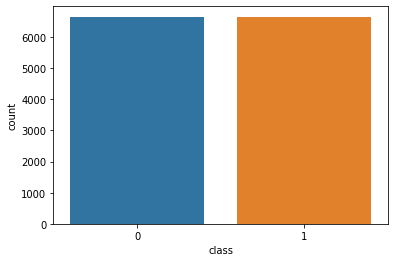

In [97]:
# Revisamos las clases
sns.countplot(bal_data_y)

Se observa que las clases ahora estan balanceadas, ahora podemos aplicar algoritmos de machine learning sin preocuparnos por la perdida de rendimiento a partir de desequilibrio de clases.

In [98]:
type(sm_data_X)

pandas.core.frame.DataFrame

In [99]:
type(sm_data_y)

pandas.core.series.Series

### Ahora, construiremos 3 clasificadores a partir de los datos preprocesados y revisaremos su rendimiento

### 1.3.1 Random Forest

In [100]:
# Entrenamos un modelo con Random Forest 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 5, max_depth=5, random_state=0)
clf.fit(bal_data_X, bal_data_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [101]:
# Aplicamos validación cruzada para evaluar el performance del modelo
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(clf, bal_data_X, bal_data_y, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.02)


In [102]:
# Hacemos predicciones con la data de prueba
predict = clf.predict(X_test)

In [103]:
predict

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [104]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[ 983,  129],
       [ 265, 1400]], dtype=int64)

In [105]:
# Revisamos otras metricas del modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.79      0.88      0.83      1112
           1       0.92      0.84      0.88      1665

    accuracy                           0.86      2777
   macro avg       0.85      0.86      0.85      2777
weighted avg       0.86      0.86      0.86      2777



In [ ]:
Interpretación de Resultados

Precisión: Se observa que el clasificador etiqueta de excelente forma ambas clases, sin embargo hay una oportunidad de mejorar la tasa de precisión para la clase "0".

Recall: Vemos que el clasificador tiene un buena capacidad para encontrar los casos positivos, y vemos que maneja un rendimiento similar para ambas clases, siendo mejor para la clase "0".

F1-Score: Encontramos que el clasificador tiene un buena capacidad de predecir bien los casos positivos. Nuevamente se puede observar que lo hace mejor manera para la clase "1"

### 1.3.2 Redes Neuronales

In [106]:
# Entrenamos un modelo con Redes Neuronales
model = keras.Sequential([
    #keras.layers.Dense(len(bal_data_X.columns), activation=tf.nn.relu, input_shape=[len(bal_data_X.columns)]),
    #keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(len(bal_data_X.columns), activation=tf.nn.relu, input_shape=[len(bal_data_X.columns)]),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [107]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [108]:
model.fit(bal_data_X, bal_data_y, epochs=5)

Train on 13314 samples
Epoch 1/5
13314/13314 [==============================] - 8s 624us/sample - loss: 0.2861 - acc: 0.9090
Epoch 2/5
13314/13314 [==============================] - 8s 573us/sample - loss: 0.0793 - acc: 0.9725
Epoch 3/5
13314/13314 [==============================] - 9s 648us/sample - loss: 0.0634 - acc: 0.9787
Epoch 4/5
13314/13314 [==============================] - 8s 603us/sample - loss: 0.0621 - acc: 0.9826
Epoch 5/5
13314/13314 [==============================] - 8s 606us/sample - loss: 0.0388 - acc: 0.9890


In [109]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

2777/2777 [==============================] - 1s 270us/sample - loss: 0.2001 - acc: 0.9377
Test accuracy: 0.93770254


In [110]:
# Hacemos predicciones con la data de prueba
predict = model.predict_classes(X_test)

In [112]:
#from sklearn.model_selection import KFold
 
#n_split=3
 
#for train_index,test_index in KFold(n_split).split(bal_data_X, bal_data_y):
 # x_train,x_test = bal_data_X[train_index],bal_data_X[test_index]
  #y_train1,y_test1 = bal_data_y[train_index],bal_data_y[test_index]
  
  #model=create_model()
  #model.fit(x_train, y_train1, epochs=5)
  
  #print('Model evaluation ',model.evaluate(x_test,y_test1))

In [113]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[1038,   74],
       [  99, 1566]], dtype=int64)

In [114]:
# Revisamos otras metricas del modelo
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.91      0.93      0.92      1112
           1       0.95      0.94      0.95      1665

    accuracy                           0.94      2777
   macro avg       0.93      0.94      0.94      2777
weighted avg       0.94      0.94      0.94      2777



Interpretación de Resultados

Precisión: Se observa que el clasificador etiqueta de excelente forma ambas clases, manejando mejor ajuste para la clase "1".

Recall: Vemos que el clasificador tiene una excelente capacidad para encontrar los casos positivos, y vemos que maneja un rendimiento casi igual para ambas clases, siendo mejor para la clase "1".

F1-Score: Encontramos que el clasificador tiene una excelente capacidad de predecir bien los casos positivos. Nuevamente se puede observar que lo hace mejor manera para la clase "1"

### 1.3.3 XG Boost

In [230]:
# Entrenamos un modelo con XG Boost
import xgboost as xgb
model=xgb.XGBClassifier(random_state=42,learning_rate=0.01, n_estimators = 5, max_depth=5)
model.fit(bal_data_X, bal_data_y)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [231]:
# Hacemos predicciones con la data de prueba
predict = model.predict(X_test)

In [232]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[1112,    0],
       [   0, 1665]], dtype=int64)

In [233]:
# Aplicamos validación cruzada para evaluar el performance del modelo
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=42)
results = cross_val_score(model, bal_data_X, bal_data_y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 99.98% (0.02%)


In [234]:
# Revisamos otras metricas del modelo
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       1.00      1.00      1.00      1112
           1       1.00      1.00      1.00      1665

    accuracy                           1.00      2777
   macro avg       1.00      1.00      1.00      2777
weighted avg       1.00      1.00      1.00      2777



Interpretación de resultados

Se observa que el rendimiento del clasificador es del 100%, esto quiere decir que tenemos un caso de overfitting, donde el modelo ha aprendido todos los ejemplos de entrenamiento y donde no es buena la capacidad para generalizar. Es necesario revisar otro método.

### 1.3.4 Regresión Logística

In [235]:
# Entrenamos el modelo con regresión logística
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(bal_data_X, bal_data_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [236]:
# Hacemos predicciones con la data de prueba
predict = lr.predict(X_test)

In [237]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[1072,   40],
       [  51, 1614]], dtype=int64)

In [238]:
# Aplicamos validación cruzada para evaluar el performance del modelo
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=42)
results = cross_val_score(lr, bal_data_X, bal_data_y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 98.02% (0.71%)


In [239]:
# Revisamos otras metricas del modelo
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.95      0.96      0.96      1112
           1       0.98      0.97      0.97      1665

    accuracy                           0.97      2777
   macro avg       0.97      0.97      0.97      2777
weighted avg       0.97      0.97      0.97      2777



Interpretación de Resultados

Precisión: Se observa que el clasificador etiqueta de excelente forma ambas clases, manejando mejor ajuste para la clase "1".

Recall: Vemos que el clasificador tiene una excelente capacidad para encontrar los casos positivos, y vemos que maneja un rendimiento casi igual para ambas clases, siendo mejor para la clase "1".

F1-Score: Encontramos que el clasificador tiene una excelente capacidad de predecir bien los casos positivos. Nuevamente se puede observar que lo hace mejor manera para la clase "1"

# 2- Clasificación con Selección

## 2.1.1 Selección de Variables

In [126]:
# Revisamos valores nulos
resum_missing(df_dep).head(10)

,Total,Porcentaje
tausw9,0,0.0
MoranAuto_Mutability7,0,0.0
MoranAuto_Mutability24,0,0.0
MoranAuto_Mutability25,0,0.0
MoranAuto_Mutability26,0,0.0
MoranAuto_Mutability27,0,0.0
MoranAuto_Mutability28,0,0.0
MoranAuto_Mutability29,0,0.0
MoranAuto_Mutability3,0,0.0
MoranAuto_Mutability30,0,0.0


In [127]:
bal_data_X.describe()

,num,A,AA,AC,AD,AE,AF,AG,AH,AI,...,tausw28,tausw29,tausw3,tausw30,tausw4,tausw5,tausw6,tausw7,tausw8,tausw9
count,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,...,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000
mean,-0.178023,0.001265,-0.014507,-0.004663,0.014347,0.012347,0.016719,-0.002633,-0.005969,0.000705,...,0.010578,0.011335,0.004952,0.011040,0.019956,-0.004714,0.000432,0.027854,0.018065,0.005683
std,1.005364,0.968659,0.957377,0.972517,1.011846,0.987063,1.007835,0.984675,0.952502,0.964837,...,1.010887,1.017292,0.991851,1.005320,1.000095,0.989553,0.984848,0.992808,0.990168,0.984289
min,-1.731926,-0.863028,-0.296462,-0.148970,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,-1.833369,-0.245378,-1.698984,-1.638773,-1.529407,-1.409979,-1.321731,-1.237456
25%,-1.054157,-0.863028,-0.296462,-0.148970,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,-0.739959,-0.245378,-0.726904,-0.739137,-0.731828,-0.748304,-0.758260,-0.773703
50%,-0.344464,-0.192676,-0.296462,-0.148970,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,-0.155416,-0.245378,-0.127035,-0.175843,-0.166769,-0.123821,-0.137206,-0.178123
75%,0.691111,0.477554,-0.296462,-0.148970,-0.168532,-0.179553,-0.205495,-0.288130,-0.145561,-0.255284,...,-0.306448,-0.281046,0.613331,-0.245378,0.612360,0.592140,0.588233,0.642260,0.602339,0.616462
max,1.731926,9.995793,16.130498,17.857778,20.457451,16.877595,19.191155,13.634235,20.746522,15.401839,...,10.219024,8.902564,4.725582,10.848186,4.778758,4.777545,6.433133,4.590796,4.327463,4.710282


### RFE Random Forest

In [128]:
rf = RandomForestClassifier(n_estimators = 10, max_depth=5, random_state=42)
rf.fit(bal_data_X, bal_data_y)
mask = rf.feature_importances_ > .01
X_reduced = bal_data_X.loc[:, mask]
print(X_reduced.columns)

Index(['num', 'GearyAuto_Mutability5', 'GearyAuto_Mutability6', 'KK', 'M',
       'MoreauBrotoAuto_Mutability7', 'QSOSW12', 'QSOSW13', 'QSOSW17',
       'QSOgrant12', 'QSOgrant13', 'QSOgrant6', 'S', '_ChargeC3',
       '_ChargeD3050', '_ChargeT12', '_HydrophobicityD2001',
       '_HydrophobicityD3001', '_PolarityC3', '_PolarityD1001',
       '_PolarizabilityD3025', '_SecondaryStrD1001', '_SecondaryStrD2025',
       '_SecondaryStrD3001', '_SolventAccessibilityC1',
       '_SolventAccessibilityD1025', '_SolventAccessibilityD3001',
       '_SolventAccessibilityD3100', '_SolventAccessibilityT23',
       'isoelectric_point'],
      dtype='object')


In [129]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=RandomForestClassifier(n_estimators = 8, max_depth=8, random_state=42), n_features_to_select=400, verbose=0)
rfe.fit(bal_data_X, bal_data_y)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=8, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=8, n_jobs=None,
                                     oob_score=False, random_state=42,
                                     verbose=0, warm_start=False),
    n_features_to_select=400, step=1, verbose=0)

In [130]:
rfe_vals = bal_data_X.columns[rfe.support_]
print(rfe_vals)

Index(['num', 'A', 'AA', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI',
       ...
       'embed_0_39', 'embed_0_4', 'embed_0_40', 'embed_0_41', 'embed_0_43',
       'embed_0_44', 'embed_0_47', 'embed_0_49', 'embed_0_50', 'embed_0_51'],
      dtype='object', length=400)


## 2.1.2 Extracción de Variables

In [131]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(scaled_df)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [132]:
print(pca.explained_variance_ratio_)

[1.20047620e-01 3.04678711e-02 2.52701438e-02 ... 7.45319666e-34
 7.45319666e-34 7.45319666e-34]


In [133]:
print(pca.explained_variance_ratio_.cumsum())

[0.12004762 0.15051549 0.17578564 ... 1.         1.         1.        ]


### Miramos el número de componentes que explican la varianza

In [134]:
variance = pca.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

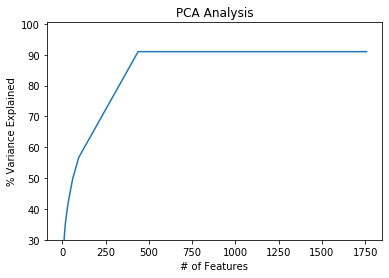

In [135]:
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

## 2.1.3 Peso de la Evidencia y valor de la información

In [136]:
# Seleccionamos las variables mas importantes a partir de votos de modelos
vs = VotingSelector()

vs.fit(bal_data_X, bal_data_y)

VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=0, no_of_features=879,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [214]:
delta_crit = 3
priorizadas = vs.feature_votes_[vs.feature_votes_["Votes"]>delta_crit]["Variable_Name"].values
print("Estas son las variables más importantes, según el consenso de votos de selección,", \
      delta_crit+1," donde las columnas de interes son:",\
      priorizadas)

Estas son las variables más importantes, según el consenso de votos de selección, 4  donde las columnas de interes son: ['M' 'embed_2_22' 'embed_2_65' 'embed_2_42' '_PolarizabilityD2001'
 'GearyAuto_ResidueASA2' 'GearyAuto_ResidueVol9' '_NormalizedVDWVD2050'
 'MS' 'embed_0_50' 'embed_1_41' 'embed_0_62' 'QSOSW16' 'embed_0_29'
 'embed_0_40' 'embed_0_94' '_ChargeD1025' 'N' 'GearyAuto_FreeEnergy15'
 'GearyAuto_FreeEnergy2' 'MoranAuto_Hydrophobicity11'
 'MoreauBrotoAuto_Mutability10' 'embed_2_25' 'GearyAuto_ResidueASA1'
 'embed_0_49' 'QSOgrant21' 'QSOSW21' 'QSOgrant24' 'QSOSW24' 'Y'
 'GearyAuto_FreeEnergy5' 'embed_1_62' 'R' 'embed_1_65' 'embed_2_94'
 '_NormalizedVDWVD1100' 'C' 'embed_1_49' '_HydrophobicityC1' 'QSOSW3'
 'QSOgrant3' 'QSOgrant19' '_HydrophobicityD3025' '_PolarizabilityC1'
 '_SolventAccessibilityD1050' '_PolarizabilityD1100' 'taugrant4'
 '_PolarityD2025' 'GearyAuto_Hydrophobicity15' '_SecondaryStrD2025'
 'embed_2_57' 'embed_2_41' 'embed_0_42' 'embed_1_57' '_ChargeT13'
 'MoreauB

## 2.2 Entrenar con las caracteristicas seleccionadas

In [138]:
#file_= glob.glob('Datos/val/DatosValidacion1.csv')
val_data = pd.read_csv('Datos/val/DatosValidacion1.csv')
# Creamos una columna enumerando cada fila
val_data = val_data.assign(num=[1500 + i for i in range(len(val_data))])[['num'] + val_data.columns.tolist()]
val_data.pop("sequence")
y2 = val_data.pop("class")
val_data.head()

,num,Unnamed: 0,Unnamed: 0.1,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,...,embed_2_90,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99
0,1500,0,0,33,3897.77,8.691,0.002230,11.404358,-0.112121,84.766667,...,-0.928374,2.771416,-0.851930,-0.459909,0.909622,1.402783,-3.848056,-0.528822,-0.740751,-0.257650
1,1501,1,1,34,4003.64,7.590,0.001896,10.196106,-0.638235,76.035294,...,-1.030314,2.356963,-0.590644,-0.433246,0.362768,1.204798,-3.838024,-0.859893,-1.086264,0.052278
2,1502,2,2,35,4121.92,6.689,0.001623,9.611023,-0.551429,16.851429,...,-0.846578,2.762231,-1.182640,-0.908285,0.802487,1.546229,-4.543212,-0.786475,-0.477468,-0.178319
3,1503,3,3,31,3838.56,6.589,0.001717,9.802917,-0.200000,53.977419,...,-0.960986,1.742604,-0.981736,-0.098695,0.614634,0.774174,-2.818301,-0.395545,-0.738405,0.369630
4,1504,4,4,33,3715.45,3.591,0.000967,8.981384,0.660606,62.042424,...,-1.034936,1.734715,-0.830263,-0.386610,0.836167,0.859871,-3.665342,-0.922017,-0.364447,-0.055827


In [139]:
# Normalizamos el set de datos
names = val_data.columns
scaler = preprocessing.StandardScaler()
scaled_val_data = scaler.fit_transform(val_data)
scaled_val_data  = pd.DataFrame(scaled_val_data, columns=names)
scaled_val_data.head()

,num,Unnamed: 0,Unnamed: 0.1,length,molecular_weight,charge,charge_density,isoelectric_point,gravy,instability_index,...,embed_2_90,embed_2_91,embed_2_92,embed_2_93,embed_2_94,embed_2_95,embed_2_96,embed_2_97,embed_2_98,embed_2_99
0,-1.730984,-1.704958,-1.710290,1.200441,1.488957,2.993163,2.041380,1.680420,0.057637,1.795329,...,-0.709365,1.945619,-1.703364,0.675871,1.054814,3.373537,-2.357323,0.456880,-0.985170,-1.610517
1,-1.728850,-1.703898,-1.709234,1.346667,1.627166,2.600490,1.720552,1.201197,-0.688985,1.474132,...,-0.996886,1.241833,-0.840013,0.748034,-0.608378,2.709067,-2.344236,-0.497817,-2.046474,-0.469698
2,-1.726715,-1.702838,-1.708178,1.492893,1.781575,2.279148,1.458301,0.969138,-0.565795,-0.703036,...,-0.478661,1.930022,-2.796106,-0.537628,0.728976,3.854966,-3.264137,-0.286104,-0.176447,-1.318507
3,-1.724581,-1.701777,-1.707123,0.907989,1.411661,2.243483,1.548356,1.045248,-0.067074,0.662700,...,-0.801345,0.198585,-2.132271,1.653474,0.157642,1.263816,-1.014032,0.841203,-0.977964,0.698452
4,-1.722446,-1.700717,-1.706067,1.200441,1.250947,1.174245,0.827828,0.719407,1.154235,0.959383,...,-1.009921,0.185188,-1.631771,0.874250,0.831410,1.551430,-2.118977,-0.676961,0.170717,-0.867622


In [140]:
data_val_x = scaled_val_data[rfe_vals]
data_val_y = y2

## 2.2.1 Random Forest (Validación)

In [215]:
# Entrenamos un modelo con Random Forest 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 5, max_depth=5, random_state=42)
rf.fit(bal_data_X[priorizadas], bal_data_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [216]:
# Hacemos predicciones con la data de prueba
predict = rf.predict(X_test[priorizadas])

In [217]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[1000,  112],
       [ 137, 1528]], dtype=int64)

In [218]:
# Revisamos otras metricas del modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.88      0.90      0.89      1112
           1       0.93      0.92      0.92      1665

    accuracy                           0.91      2777
   macro avg       0.91      0.91      0.91      2777
weighted avg       0.91      0.91      0.91      2777



## 2.2.2 Redes Neuronales (Validación)

In [219]:
n_net = keras.Sequential([
    #keras.layers.Dense(len(bal_data_X.columns), activation=tf.nn.relu, input_shape=[len(bal_data_X.columns)]),
    #keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(len(bal_data_X[priorizadas].columns), activation=tf.nn.relu, input_shape=[len(bal_data_X[priorizadas].columns)]),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

In [220]:
n_net.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [221]:
n_net.fit(bal_data_X[priorizadas], bal_data_y, epochs=5)

Train on 13314 samples
Epoch 1/5
13314/13314 [==============================] - 4s 293us/sample - loss: 0.1842 - acc: 0.9277
Epoch 2/5
13314/13314 [==============================] - 5s 353us/sample - loss: 0.0650 - acc: 0.9753
Epoch 3/5
13314/13314 [==============================] - 4s 327us/sample - loss: 0.0380 - acc: 0.9880
Epoch 4/5
13314/13314 [==============================] - 7s 508us/sample - loss: 0.0367 - acc: 0.9881
Epoch 5/5
13314/13314 [==============================] - 4s 321us/sample - loss: 0.0274 - acc: 0.9913


In [222]:
predict = n_net.predict_classes(X_test[priorizadas])

In [223]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[1077,   35],
       [  52, 1613]], dtype=int64)

In [224]:
# Revisamos otras metricas del modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.95      0.97      0.96      1112
           1       0.98      0.97      0.97      1665

    accuracy                           0.97      2777
   macro avg       0.97      0.97      0.97      2777
weighted avg       0.97      0.97      0.97      2777



## 2.2.3 Regresión Logística (Validación)

In [225]:
lr = LogisticRegression()
lr.fit(bal_data_X[priorizadas], bal_data_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [226]:
predict = lr.predict(X_test[priorizadas])

In [227]:
# Revisamos la matriz de confusión
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predict)

array([[1095,   17],
       [  25, 1640]], dtype=int64)

In [228]:
# Revisamos otras metricas del modelo
from sklearn.metrics import classification_report
print(classification_report(y_test, predict))

precision    recall  f1-score   support

           0       0.98      0.98      0.98      1112
           1       0.99      0.98      0.99      1665

    accuracy                           0.98      2777
   macro avg       0.98      0.98      0.98      2777
weighted avg       0.98      0.98      0.98      2777

